# Artificial Intelligence for Communication and Marketing: Lab Exam

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap

from scipy.stats import chi2_contingency, ttest_ind
from sklearn.model_selection import train_test_split, StratifiedKFold
from hyperopt import hp, STATUS_OK, Trials, fmin, tpe
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc, average_precision_score, classification_report

## Exploratory Data Analysis

### Data Overview

In [7]:
# Load the new dataset
data_df = pd.read_excel('data.xlsx')
data_df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001.0,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002.0,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003.0,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004.0,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005.0,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


First things first, we want to check the high-level features of the dataset, such as the number of rows and columns, the number of null values, and whether the column types match the dataset description.

In [8]:
# Familiarize with the dataset
clean_df = data_df.copy() 

print("Dataset Info:")
clean_df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5628 non-null   float64
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5628 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  Numb

With the exception of 'CashbackAmount', it seems, at a first glance, that the other float columns don't actually use any decimal different from 0. It may be just because they contain missing values, and the default dtype associated in that case is 'float64', as nan values are treated as floats. If this is the case, there is no actual need to change the dtype to 'int', but it's important to keep that in mind at imputation time, as we would rather use 'median' than 'mean' if there are no actual decimals!

In [9]:
for col_name in clean_df.columns:
    if clean_df[col_name].dtype == 'float64':
        # Drop NaN values before checking for decimal parts
        non_nan_values = clean_df[col_name].dropna()
        has_decimals = (non_nan_values % 1 != 0).any()
        
        if not has_decimals:
            print(f"Column '{col_name}': Contains only whole numbers or NaNs. Should be treated as int.")
        else:
            print(f"Column '{col_name}': Contains actual decimal values. Should remain float.")

Column 'CustomerID': Contains only whole numbers or NaNs. Should be treated as int.
Column 'Tenure': Contains only whole numbers or NaNs. Should be treated as int.
Column 'WarehouseToHome': Contains only whole numbers or NaNs. Should be treated as int.
Column 'HourSpendOnApp': Contains only whole numbers or NaNs. Should be treated as int.
Column 'OrderAmountHikeFromlastYear': Contains only whole numbers or NaNs. Should be treated as int.
Column 'CouponUsed': Contains only whole numbers or NaNs. Should be treated as int.
Column 'OrderCount': Contains only whole numbers or NaNs. Should be treated as int.
Column 'DaySinceLastOrder': Contains only whole numbers or NaNs. Should be treated as int.
Column 'CashbackAmount': Contains actual decimal values. Should remain float.


As we expected, values from almost all numerical columns should be treated as integers. We will keep that in mind when inputing the missing values. 

We also notice that, while having our target variable in 0/1 is quite convenient, we could use a small transformation to make the 'Complain' column more straightforward and easily interpretable, switching to Yes/No instead. We can always quickly switch back if we need it for model development.

In [10]:
clean_df['Complain'] = np.where(clean_df['Complain']==1, 'Yes', 'No')

Now let's deep dive into the distribution of both numerical and categorical columns.

In [11]:
# Numerical columns
clean_df.describe(percentiles=[.01,.1,.25,.5,.75,.90,.95,.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,95%,99%,max
CustomerID,5628.0,52814.549041,1624.890759,50001.0,50057.27,50563.70,51407.75,52814.50,54221.2500,55065.30,55346.6500,55573.7300,55630.0
Churn,5630.0,0.168384,0.374240,0.0,0.00,0.00,0.00,0.00,0.0000,1.00,1.0000,1.0000,1.0
Tenure,5366.0,10.189899,8.557241,0.0,0.00,1.00,2.00,9.00,16.0000,23.00,27.0000,30.0000,61.0
CityTier,5630.0,1.654707,0.915389,1.0,1.00,1.00,1.00,1.00,3.0000,3.00,3.0000,3.0000,3.0
WarehouseToHome,5379.0,15.639896,8.531475,5.0,6.00,7.00,9.00,14.00,20.0000,30.00,33.0000,35.0000,127.0
HourSpendOnApp,5375.0,2.931535,0.721926,0.0,2.00,2.00,2.00,3.00,3.0000,4.00,4.0000,4.0000,5.0
NumberOfDeviceRegistered,5630.0,3.688988,1.023999,1.0,1.00,3.00,3.00,4.00,4.0000,5.00,5.0000,6.0000,6.0
SatisfactionScore,5630.0,3.066785,1.380194,1.0,1.00,1.00,2.00,3.00,4.0000,5.00,5.0000,5.0000,5.0
NumberOfAddress,5630.0,4.214032,2.583586,1.0,1.00,2.00,2.00,3.00,6.0000,8.00,10.0000,11.0000,22.0
OrderAmountHikeFromlastYear,5365.0,15.707922,3.675485,11.0,11.00,12.00,13.00,15.00,18.0000,21.00,23.0000,25.0000,26.0


From description of the numerical columns, we can see the maximum value for 'CashbackAmount' being 999999.0, which really seems off.

In [12]:
clean_df[clean_df['CashbackAmount'] == 999999.0]

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
590,50591.0,0,6.0,Computer,1,6.0,UPI,Female,2.0,1,Laptop & Accessory,4,Divorced,2,Yes,13.0,0.0,1.0,2.0,999999.0
5518,55519.0,0,5.0,Mobile Phone,3,17.0,Credit Card,Female,3.0,4,Laptop & Accessory,1,Married,4,Yes,12.0,2.0,2.0,5.0,999999.0


Let's do some calculations to check if our suspicions are correct. We can compare the mean value with and without the alledged outlier, and see if it is actually skewed and by how much; then we can check with the median value, which tells us which value is central in our distribution. 

In [13]:
mean_with_outlier = clean_df['CashbackAmount'].mean()
mean_without_outlier = clean_df[clean_df['CashbackAmount'] != 999999.0]['CashbackAmount'].mean()
difference = mean_with_outlier - mean_without_outlier
diff_percentage = (difference / mean_without_outlier) * 100

print(f"Mean 'CashbackAmount' (with outlier): {mean_with_outlier:.2f}")
print(f"Mean 'CashbackAmount' (without outlier): {mean_without_outlier:.2f}")
print(f"\nThe value 999999.0 skews the mean by {diff_percentage:.2f}%")

Mean 'CashbackAmount' (with outlier): 532.40
Mean 'CashbackAmount' (without outlier): 177.22

The value 999999.0 skews the mean by 200.41%


In [14]:
# Median check
median_value = clean_df['CashbackAmount'].median()
print(f"Median 'CashbackAmount': {median_value:.2f}")

Median 'CashbackAmount': 163.33


The skewness is huge! The median value also being much closer to the mean without the outlier confirms its nature. Be they registration errors or a way to signal missing values, there are just two entries of such type, so we can simply proceed by filtering them out. 

In [15]:
clean_df = clean_df[clean_df['CashbackAmount'] != 999999.0].reset_index(drop=True)
clean_df['CashbackAmount'].describe(percentiles=[.01,.1,.25,.5,.75,.90,.95,.99])

count    5628.000000
mean      177.224582
std        49.214545
min         0.000000
1%        116.010000
10%       126.860000
25%       145.765000
50%       163.280000
75%       196.400000
90%       259.720000
95%       291.945500
99%       318.755300
max       324.990000
Name: CashbackAmount, dtype: float64

Now it's definitely more reasonable.

In [16]:
# Categorical columns
for column in clean_df.columns:
        if column in ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus']:
                print("Column: {} - Unique Values: {}".format(column, clean_df[column].unique()))
                print("="*120)

Column: PreferredLoginDevice - Unique Values: ['Mobile Phone' 'Phone' 'Computer' 'N.A.']
Column: PreferredPaymentMode - Unique Values: ['Debit Card' 'UPI' 'CC' 'Cash on Delivery' 'E wallet' 'COD' 'Credit Card']
Column: Gender - Unique Values: ['Female' 'Male' nan]
Column: PreferedOrderCat - Unique Values: ['Laptop & Accessory' 'Mobile' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']
Column: MaritalStatus - Unique Values: ['Single' 'Divorced' 'Married' 'Widow']


We can clearly see that a few unique values for different variables actually refer to the same category, meaning we can merge their instances. 

For the preferred login device, we make the assumption that a login operation can only be performed through a mobile phone (no landline). Consequently, we can merge "mobile phone" with "phone". Also, the "N.A." category should be treated as missing values. 

The sistuation is more straightforward for the preferred payment mode and the preferred order category: "CC" and "Credit Card" can be merged, just like "COD" and "Cash on Delivery" belong to the same category, and so do "Mobile" and "Mobile Phone". 

In [17]:
clean_df['PreferredLoginDevice'] = clean_df['PreferredLoginDevice'].replace({'Phone': 'Mobile Phone'})
clean_df['PreferredLoginDevice'] = clean_df['PreferredLoginDevice'].replace('N.A.', np.nan)
clean_df['PreferredPaymentMode'] = clean_df['PreferredPaymentMode'].replace({'CC': 'Credit Card', 'COD': 'Cash on Delivery'})
clean_df['PreferedOrderCat'] = clean_df['PreferedOrderCat'].replace({'Mobile': 'Mobile Phone'})

In [18]:
for column in clean_df.columns:
        if column in ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus']:
                print("Column: {} - Unique Values: {}".format(column, clean_df[column].unique()))
                print("="*100)

Column: PreferredLoginDevice - Unique Values: ['Mobile Phone' 'Computer' nan]
Column: PreferredPaymentMode - Unique Values: ['Debit Card' 'UPI' 'Credit Card' 'Cash on Delivery' 'E wallet']
Column: Gender - Unique Values: ['Female' 'Male' nan]
Column: PreferedOrderCat - Unique Values: ['Laptop & Accessory' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']
Column: MaritalStatus - Unique Values: ['Single' 'Divorced' 'Married' 'Widow']


In [19]:
# Let's also check for duplicates
clean_df.duplicated().sum()

np.int64(0)

No duplicates found!

### Missingness Investigation

Another interesting study we can perform is on the nature of missing values: are they missing completely at random (**MCAR**), missing at random (**MAR**), or missing not at random (**MNAR**)? We can explore the relationship with the target variable and other features to determine it. 

In [20]:
# Check for missing values
print("Missing Values")
print(clean_df.isnull().sum())

Missing Values
CustomerID                       2
Churn                            0
Tenure                         264
PreferredLoginDevice             5
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           2
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64



--- Churn Rate by MissingTenure ---
MissingTenure
0    0.161633
1    0.306818
Name: Churn, dtype: float64


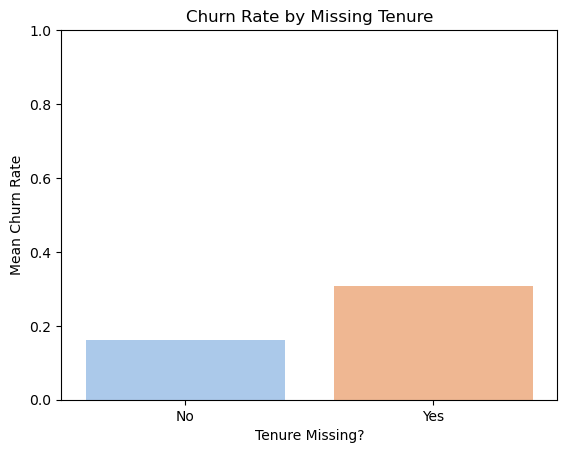


--- Churn Rate by MissingWarehouseToHome ---
MissingWarehouseToHome
0    0.160684
1    0.334661
Name: Churn, dtype: float64


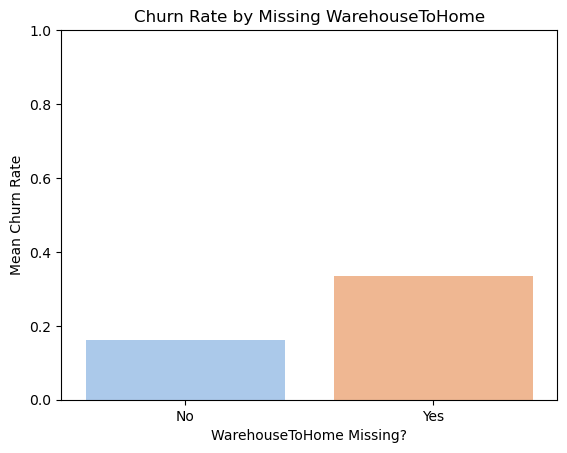


--- Churn Rate by MissingHourSpendOnApp ---
MissingHourSpendOnApp
0    0.165643
1    0.227451
Name: Churn, dtype: float64


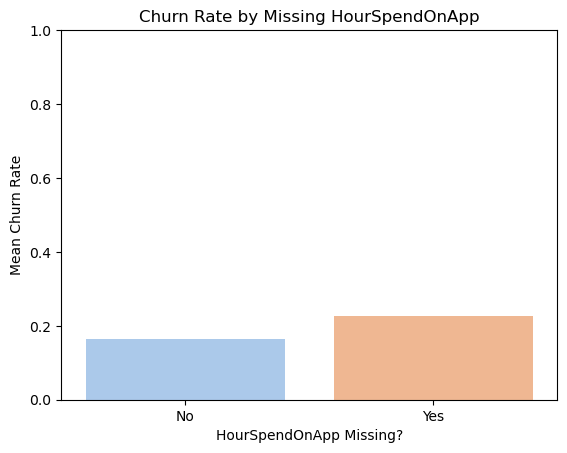


--- Churn Rate by MissingOrderAmountHikeFromlastYear ---
MissingOrderAmountHikeFromlastYear
0    0.174156
1    0.052830
Name: Churn, dtype: float64


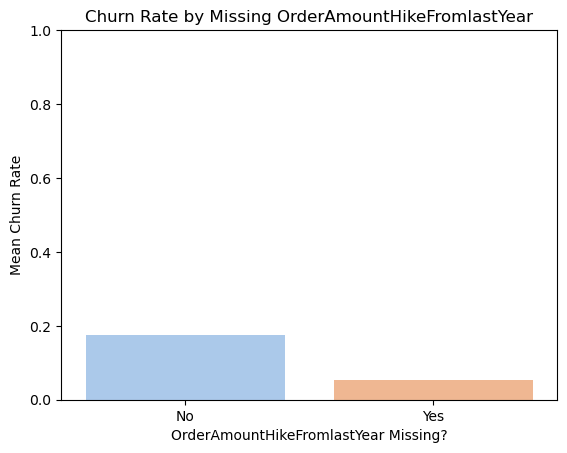


--- Churn Rate by MissingCouponUsed ---
MissingCouponUsed
0    0.174981
1    0.031250
Name: Churn, dtype: float64


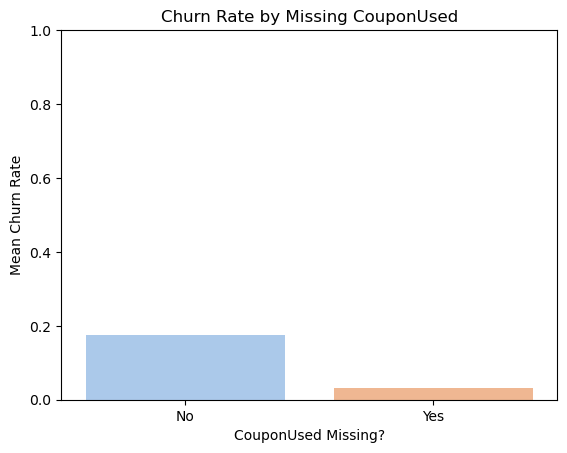


--- Churn Rate by MissingOrderCount ---
MissingOrderCount
0    0.173184
1    0.069767
Name: Churn, dtype: float64


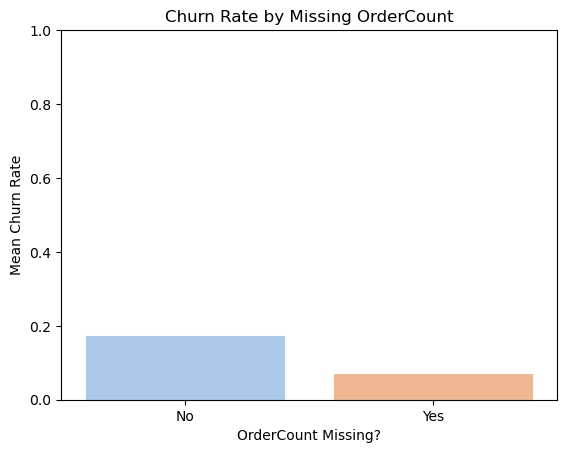


--- Churn Rate by MissingDaySinceLastOrder ---
MissingDaySinceLastOrder
0    0.168014
1    0.175896
Name: Churn, dtype: float64


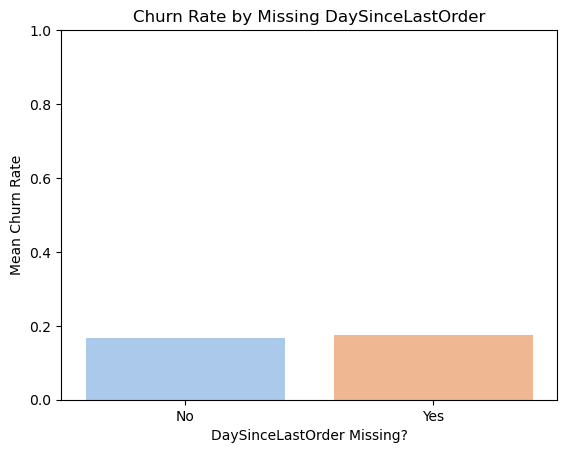

In [21]:
for col in ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder']:

    # Create an indicator columns for those with missing values: 1 if missing, 0 otherwise
    new_col = 'Missing' + col
    clean_df[new_col] = clean_df[col].isnull().astype(int)

    churn_rate_by_col = clean_df.groupby(new_col)['Churn'].mean()
    print(f"\n--- Churn Rate by {new_col} ---")
    print(churn_rate_by_col)

    # Plot
    churn_rate_by_col.index = ['No', 'Yes']  # Renaming index for clarity
    sns.barplot(x=churn_rate_by_col.index, y=churn_rate_by_col.values, hue=churn_rate_by_col.index, legend=False, palette='pastel')
    plt.title('Churn Rate by Missing ' + col)
    plt.ylabel('Mean Churn Rate')
    plt.xlabel(col + ' Missing?')
    plt.ylim(0, 1)
    plt.show()

This exploration highlights very interesting patterns. 

For 'WarehouseToHome' and 'Tenure', missing data is a fairly strong indicator of churning, with the probability doubling when the values are not present (16.1% vs. 33.5%, 16.2 vs. 30.7%): this likely points to new or disengaged users for whom the company hasn't yet established a clear tenure record. 

For 'OrderAmountHikeFromlastYear', 'CouponUsed', and 'OrderCount', we also have fascinating and very strong signal, but in the opposite direction. When data for these recent activity metrics is missing, customers are far less likely to churn (respectively, 17.4% vs. 5.3%, 17.5% vs. 3.1%, 17.3% vs. 7.0%). This could mean these fields are only populated for customers who have been active recently. The absence of this data might indicate a long-term, stable customer who doesn't show an irregular pattern and simply likely hasn't had a recent order to generate these metrics.

'HourSpendOnApp' produces a moderately strong correlation as well: customers with missing app usage data have a noticeably higher churn rate (16.6% vs. 22.7%). This suggests they are less engaged with the platform's app, which is a logical precursor to churning.		

For this reason, I have decided to include the missingness itself as a relevant feature of the dataset, as it shows remarkable signs of not being completely random. The only exception is 'DaySinceLastOrder', which doesn't show relevant correlations with churning, and can thus be assumed to just be random.  

In [22]:
clean_df.drop(columns=['MissingDaySinceLastOrder'], inplace=True)

### Handling Missing Values

Finally, the time has come to handle columns with missing values. Since 'Gender' only has two, we can safely drop them without losing information, while for the other numerical columns involved, we will use the median to avoid generating non-existing float values. 

In [23]:
clean_df = clean_df.dropna(axis=0, subset='Gender').reset_index(drop=True)

for col in ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder']:
    if clean_df[col].isnull().any():
        median_val = clean_df[col].median()
        clean_df.loc[:, col] = clean_df[col].fillna(median_val)

mode_login = clean_df['PreferredLoginDevice'].mode()[0]
clean_df['PreferredLoginDevice'] = clean_df['PreferredLoginDevice'].fillna(mode_login)

print("--- Missing Values After Imputation ---")
print(clean_df.isnull().sum())

--- Missing Values After Imputation ---
CustomerID                            2
Churn                                 0
Tenure                                0
PreferredLoginDevice                  0
CityTier                              0
WarehouseToHome                       0
PreferredPaymentMode                  0
Gender                                0
HourSpendOnApp                        0
NumberOfDeviceRegistered              0
PreferedOrderCat                      0
SatisfactionScore                     0
MaritalStatus                         0
NumberOfAddress                       0
Complain                              0
OrderAmountHikeFromlastYear           0
CouponUsed                            0
OrderCount                            0
DaySinceLastOrder                     0
CashbackAmount                        0
MissingTenure                         0
MissingWarehouseToHome                0
MissingHourSpendOnApp                 0
MissingOrderAmountHikeFromlastYear    0


Again, 'CustomerID' will not be useful to our analysis, so we can drop it.

In [24]:
clean_df.drop(columns=['CustomerID'], inplace=True)

In [25]:
clean_df

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,...,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,MissingTenure,MissingWarehouseToHome,MissingHourSpendOnApp,MissingOrderAmountHikeFromlastYear,MissingCouponUsed,MissingOrderCount
0,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,...,1.0,1.0,5.0,159.93,0,0,0,0,0,0
1,1,9.0,Mobile Phone,1,8.0,UPI,Male,3.0,4,Mobile Phone,...,0.0,1.0,0.0,120.90,1,0,0,0,0,0
2,1,9.0,Mobile Phone,1,30.0,Debit Card,Male,2.0,4,Mobile Phone,...,0.0,1.0,3.0,120.28,1,0,0,0,0,0
3,1,0.0,Mobile Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,...,0.0,1.0,3.0,134.07,0,0,0,0,0,0
4,1,0.0,Mobile Phone,1,12.0,Credit Card,Male,3.0,3,Mobile Phone,...,1.0,1.0,3.0,129.60,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5621,0,10.0,Computer,1,30.0,Credit Card,Male,3.0,2,Laptop & Accessory,...,1.0,2.0,4.0,150.71,0,0,0,0,0,0
5622,0,13.0,Mobile Phone,1,13.0,Credit Card,Male,3.0,5,Fashion,...,1.0,2.0,3.0,224.91,0,0,0,0,0,0
5623,0,1.0,Mobile Phone,1,11.0,Debit Card,Male,3.0,2,Laptop & Accessory,...,1.0,2.0,4.0,186.42,0,0,0,0,0,0
5624,0,23.0,Computer,3,9.0,Credit Card,Male,4.0,5,Laptop & Accessory,...,2.0,2.0,9.0,178.90,0,0,0,0,0,0


### Final Feature Engineering

Last, but not least, we can do some more advanced feature engineering, to try and capture the most of our data patterns.

The first thing we are going to do is consider the warehouse as 'far', 'medium' or 'close' to the customer's home, raather than simply looking at a number. Binning will probably give us more insights than the actual precise distance. 

In [26]:
clean_df['WarehouseToHome'].describe(percentiles=[.25,.5,.75])

count    5626.000000
mean       15.565233
std         8.345054
min         5.000000
25%         9.000000
50%        14.000000
75%        20.000000
max       127.000000
Name: WarehouseToHome, dtype: float64

In [27]:
# Based on the distribution, we can categorize the 'WarehouseToHome' distances into bins
bins  = [5, 9, 14, 20, np.inf]
labels = ['Very Close', 'Close', 'Medium', 'Far+']
clean_df['WarehouseDistanceCategory'] = pd.cut(clean_df['WarehouseToHome'], bins=bins, labels=labels, right=False)

In [28]:
clean_df.drop(columns=['WarehouseToHome'], inplace=True)

Then, we introduce two new **ratio features, 'CouponsPerOrder' and 'CashbackPerOrder'**, which should reveal behavioral patterns that are hidden when looking at the raw numbers alone. 

We hypothesize that both coupon usage and cashback amounts, when normalized by order count, are strong predictors of churn. The assumption is that customers who are heavily reliant on any kind of discount might be less loyal.

Imagine two customers having used the same number of coupons in the last month, but with a significant difference in the number of orders: they will likely belong to very different customer segments! For instance, if customer A has used 1 coupon per order, they are a "deal-seeker", while B, spreading the same amount over more orders, is likely just a "frequent buyer" who uses coupons only occasionally. Customer A's behavior is fundamentally different from Customer B's, even though their total CouponUsed is the same.

In the same fashion, some customers might be making large, high-value purchases that generate significant cashback, while not being long-term loyal. These could be one-time bulk buyers or customers taking advantage of a single, large promotional event. After receiving their large cashback reward, they have little incentive to return and subsequently churn.

In [29]:
clean_df['CouponsPerOrder'] = np.where(clean_df['OrderCount'] == 0, 0, clean_df['CouponUsed'] / clean_df['OrderCount'])

In [30]:
clean_df['CashbackPerOrder'] = np.where(clean_df['OrderCount'] == 0, 0, clean_df['CashbackAmount'] / clean_df['OrderCount'])


Let's ground our hypotheses in statistical tests! For the 'WarehouseDistanceCategory' column, we'll use a Chi-Squared test to determine the dependence or independence of the custom variable from the target. The two numerical columns, on the other hand, requite a t-test to check whether differences in averages between the two groups are random. For both tests, we will use a 5% significance level. 

In [31]:
# Create the Contingency Table
contingency_table = pd.crosstab(clean_df['WarehouseDistanceCategory'], clean_df['Churn'])
contingency_table

Churn,0,1
WarehouseDistanceCategory,,
Very Close,993,142
Close,1320,216
Medium,1241,298
Far+,1124,292


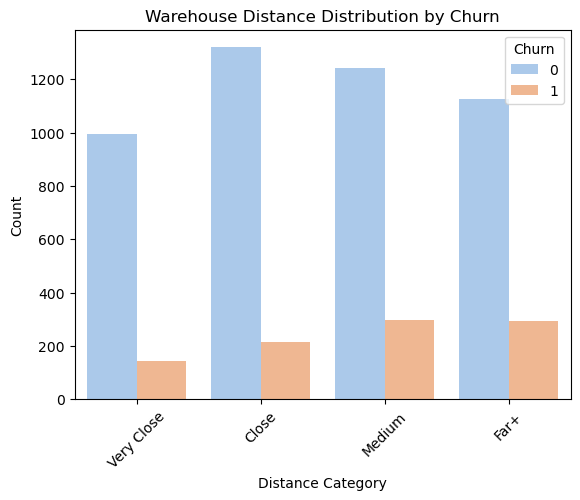

In [32]:
# Plotting the distribution of 'WarehouseDistanceCategory' by 'Churn'
sns.countplot(data=clean_df, x='WarehouseDistanceCategory', hue='Churn', palette='pastel')
plt.title('Warehouse Distance Distribution by Churn')
plt.xlabel('Distance Category')
plt.ylabel('Count')
plt.legend(title='Churn', loc='upper right')
plt.xticks(rotation=45)
plt.show()

In [33]:
# Chi-Squared Test for WarehouseDistanceCategory
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-Squared Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.9f}")
print(f"Degrees of Freedom: {dof}")

# Result interpretation
alpha = 0.05
if p_value < alpha:
    print("\nConclusion: We reject the null hypothesis.")
    print("There is a statistically significant association between WarehouseDistanceCategory and Churn.")
else:
    print("\nConclusion: We fail to reject the null hypothesis.")
    print("There is no statistically significant association between WarehouseDistanceCategory and Churn.")


Chi-Squared Statistic: 45.0827
P-value: 0.000000001
Degrees of Freedom: 3

Conclusion: We reject the null hypothesis.
There is a statistically significant association between WarehouseDistanceCategory and Churn.


In [34]:
# Separate the data into two groups: Churn vs. No Churn
coupon_churn_group = clean_df[clean_df['Churn'] == 1]['CouponsPerOrder']
coupon_no_churn_group = clean_df[clean_df['Churn'] == 0]['CouponsPerOrder']
cashback_churn_group = clean_df[clean_df['Churn'] == 1]['CashbackPerOrder']
cashback_no_churn_group = clean_df[clean_df['Churn'] == 0]['CashbackPerOrder']

# Check the average for each group 
print("--- Mean CouponsPerOrder by Group ---")
print(f"Churn Group Mean: {coupon_churn_group.mean():.4f}")
print(f"No Churn Group Mean: {coupon_no_churn_group.mean():.4f}")

print("\n--- Mean CashbackPerOrder by Group ---")
print(f"Churn Group Mean: {cashback_churn_group.mean():.4f}")
print(f"No Churn Group Mean: {cashback_no_churn_group.mean():.4f}")

--- Mean CouponsPerOrder by Group ---
Churn Group Mean: 0.6319
No Churn Group Mean: 0.6297

--- Mean CashbackPerOrder by Group ---
Churn Group Mean: 88.7630
No Churn Group Mean: 96.8739


In [35]:
# t-test for CouponsPerOrder
t_statistic, p_value = ttest_ind(coupon_churn_group, coupon_no_churn_group, equal_var=False, nan_policy='omit')

print(f"\nT-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.6f}")

# Result interpretation
alpha = 0.05
if p_value < alpha:
    print("\nConclusion: We reject the null hypothesis.")
    print("There is a statistically significant difference in CouponsPerOrder between churned and non-churned customers.")
else:
    print("\nConclusion: We fail to reject the null hypothesis.")
    print("The difference in CouponsPerOrder between the groups is not statistically significant.")


T-statistic: 0.1298
P-value: 0.896757

Conclusion: We fail to reject the null hypothesis.
The difference in CouponsPerOrder between the groups is not statistically significant.


In [36]:
# t-test for CashbackPerOrder
t_statistic, p_value = ttest_ind(cashback_churn_group, cashback_no_churn_group, equal_var=False, nan_policy='omit')

print(f"\nT-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.6f}")

# Result interpretation
alpha = 0.05
if p_value < alpha:
    print("\nConclusion: We reject the null hypothesis.")
    print("There is a statistically significant difference in CashbackPerOrder between churned and non-churned customers.")
else:
    print("\nConclusion: We fail to reject the null hypothesis.")
    print("The difference in CashbackPerOrder between the groups is not statistically significant.")


T-statistic: -4.9007
P-value: 0.000001

Conclusion: We reject the null hypothesis.
There is a statistically significant difference in CashbackPerOrder between churned and non-churned customers.


**The statistical tests revealed two valuable and unexpected insights!**

Firstly, our t-test for 'CouponsPerOrder' revealed that there is no statistically significant difference in the average between customers who churn and those who stay. This is crucial, as it suggests that being a "deal seeker" is not, by itself, a predictor of churn. Loyal customers and at-risk customers use coupons at a similar rate per transaction. Coupon usage might just be a widespread behavior across the entire customer base. 

As for 'CashbackPerOrder', we initially hypothesized that high cashback might be associated with one-off deal-seeking behavior, potentially leading to higher churn. However, our statistical analysis revealed the opposite: cashback is not just a discount, but a reward mechanism that reinforces loyal behavior. Indeed, customers who spend more receive more cashback, which incentivizes them to return and spend again, further embedding them in the ecosystem. A higher CashbackPerOrder may not just mean higher spending per order, but also a deeper engagement with the platform. These customers are likely more aware of the company's promotions, participate more actively in loyalty programs, and are more invested in maximizing their benefits.

In [37]:
# We can drop 'CouponsPerOrder'
clean_df.drop(columns=['CouponsPerOrder'], inplace=True)

Since the newly created 'WarehouseDistanceCategory' is an ordinal categorical column, we can map the bins to numbers before passing the column to the models instead of simply one-hot-encoding them, so that distance relationships are actually leveraged.

In [38]:
distance_mapping = {
    'Very Close': 0,
    'Close': 1,
    'Medium': 2,
    'Far+': 3
}

clean_df['WarehouseDistanceCategory'] = clean_df['WarehouseDistanceCategory'].map(distance_mapping).astype(int)

## Model Development

In [39]:
# Check the class balance of the target variable 'Churn'
class_balance = clean_df['Churn'].value_counts(normalize=True) * 100
print("--- Class Balance in the Dataset ---")
print(class_balance)

--- Class Balance in the Dataset ---
Churn
0    83.149662
1    16.850338
Name: proportion, dtype: float64


The dataset appears to be heavily unbalanced, which is common practice when analyzing churn. Since using undersampling comes with the high risk of losing the variety and richness of data for the majority class, we can instead exploit the intrinsic abilities of the models we'll use. Logistic Regression, Decision Trees and Random Forest can leverage the 'balanced' method to automatically adjust weights inversely proportional to class frequencies in the input data. CatBoost and XGB, on the other hand, rely on the 'scale_pos_weight' parameter, which increases the weight of the minority class in the loss function, effectively telling the model, to pay more attention to getting the churners right, even if they are few.

### Data Partitioning

In [40]:
# Train-test split
X = clean_df.drop('Churn', axis=1)
y = clean_df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Training

In [41]:
# Identify categorical and numerical feature names
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
numerical_features = X_train.select_dtypes(include=np.number).columns

In [42]:
## Pipelines 

# Logistic Regression preprocessor: one-hot encodes categorical data and scales numerical data
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# LOGISTIC REGRESSION Pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_lr),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))
])


# Decision Tree & Random Forest preprocessor: one-hot encoding only
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features), # Pass numerical features through
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# DECISION TREE Pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# RANDOM FOREST Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

In [45]:
# Logistic Regression model fitting
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['Tenure', 'CityTier', 'HourSpendOnApp', 'NumberOfDeviceRegistered',
       'SatisfactionScore', 'NumberOfAddress', 'OrderAmountHikeFromlastYear',
       'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount',
       'MissingTenure', 'MissingWarehouseToH...
       'MissingOrderCount', 'WarehouseDistanceCategory', 'CashbackPerOrder'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender',
       'PreferedOrderCat', 'MaritalStatus', 'Complain'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [46]:
# Decision Tree model fitting
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  Index(['Tenure', 'CityTier', 'HourSpendOnApp', 'NumberOfDeviceRegistered',
       'SatisfactionScore', 'NumberOfAddress', 'OrderAmountHikeFromlastYear',
       'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount',
       'MissingTenure', 'MissingWarehouseToHome...
       'MissingOrderAmountHikeFromlastYear', 'MissingCouponUsed',
       'MissingOrderCount', 'WarehouseDistanceCategory', 'CashbackPerOrder'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender',
       'PreferedOrderCat', 'MaritalStatus', 'Complain'],
      dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

In [47]:
# Random Forest model fitting
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  Index(['Tenure', 'CityTier', 'HourSpendOnApp', 'NumberOfDeviceRegistered',
       'SatisfactionScore', 'NumberOfAddress', 'OrderAmountHikeFromlastYear',
       'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount',
       'MissingTenure', 'MissingWarehouseToHome...
       'MissingOrderAmountHikeFromlastYear', 'MissingCouponUsed',
       'MissingOrderCount', 'WarehouseDistanceCategory', 'CashbackPerOrder'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender',
       'PreferedOrderCat', 'MaritalStatus', 'Complain'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

XGBoost and CatBoost need a different handling of categorical columns:

In [48]:
X_train_gb = X_train.copy()
X_test_gb = X_test.copy()
for col in categorical_features:
    X_train_gb[col] = X_train_gb[col].astype('category')
    X_test_gb[col] = X_test_gb[col].astype('category')

In [49]:
# Calculate scale_pos_weight for imbalanced classes
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

In [50]:
# XGBOOST
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    enable_categorical=True,
    tree_method='hist',
    random_state=42
)

# XGBoost model fitting
xgb_model.fit(X_train_gb, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [52]:
# CATBOOST
cat_features_indices = [X_train_gb.columns.get_loc(c) for c in categorical_features]
cat_model = CatBoostClassifier(
    iterations=200,
    verbose=0,
    random_seed=42,
    scale_pos_weight=scale_pos_weight
)

# CatBoost model fitting
cat_model.fit(X_train_gb, y_train, cat_features=cat_features_indices)
print("CatBoost fitted.")

CatBoost fitted.


### Evaluation

In [53]:
models = {
    "Logistic Regression": lr_pipeline,
    "Decision Tree": dt_pipeline,
    "Random Forest": rf_pipeline,
    "XGBoost": xgb_model,
    "CatBoost": cat_model
}

results = {}

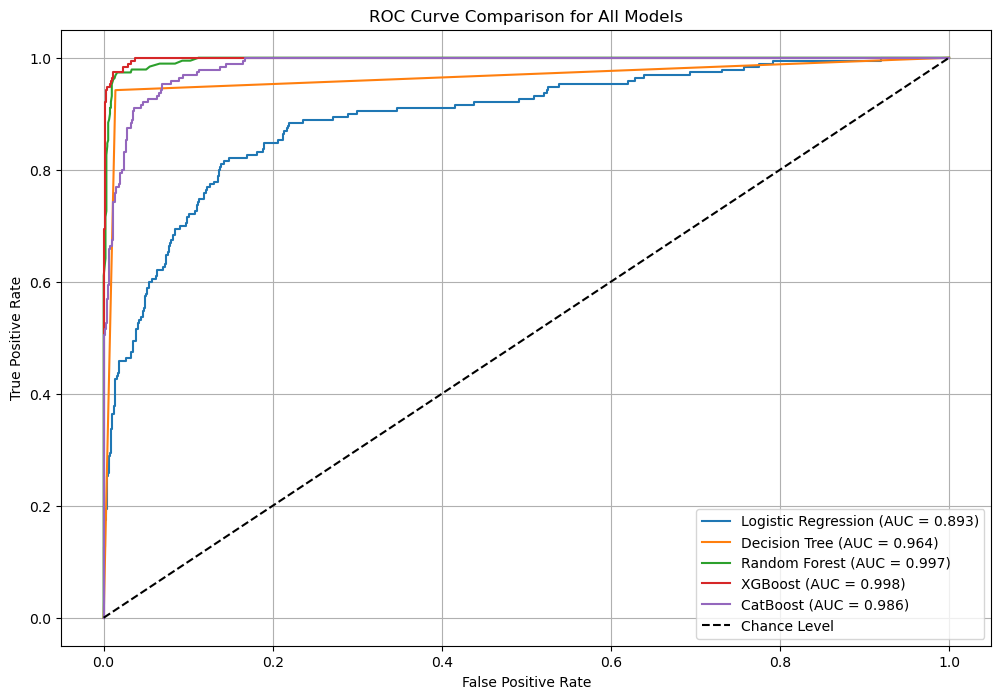

In [54]:
# Plot ROC Curves for all models
plt.figure(figsize=(12, 8))
for name, model in models.items():
    
    X_to_predict = X_test_gb if name in ['XGBoost', 'CatBoost'] else X_test
    
    y_pred_proba = model.predict_proba(X_to_predict)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance Level')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for All Models')
plt.legend(loc='best') 
plt.grid(True)
plt.show()

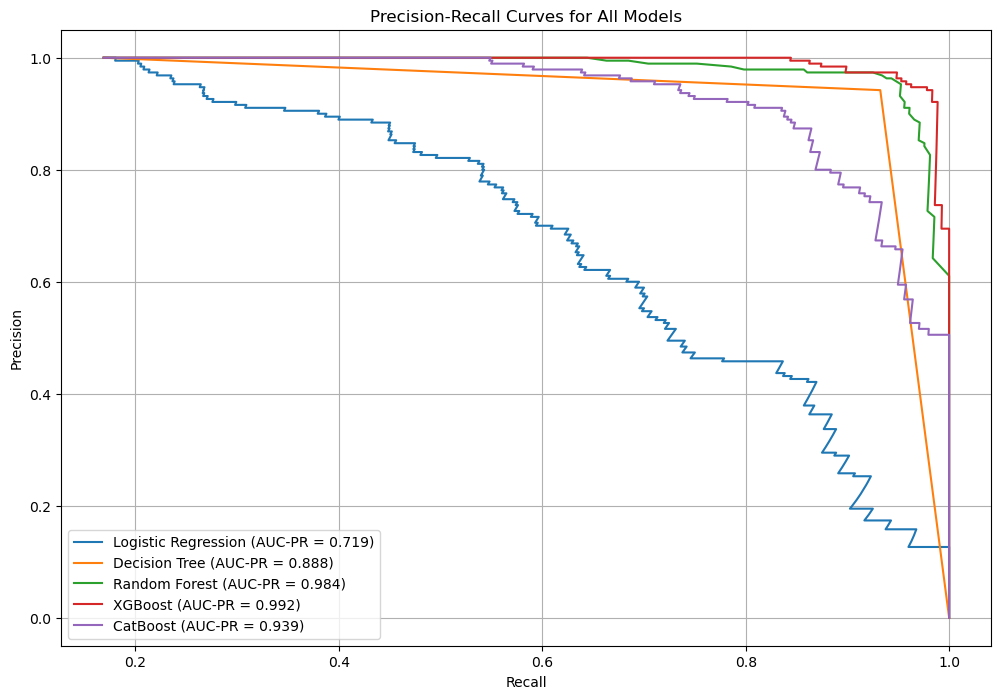

In [55]:
# Plot Precision-Recall Curves for all models
plt.figure(figsize=(12, 8))
for name, model in models.items():
    
    X_to_predict = X_test_gb if name in ['XGBoost', 'CatBoost'] else X_test
    
    y_pred_proba = model.predict_proba(X_to_predict)[:, 1]
    prec, rec, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    plt.plot(prec, rec, label=f'{name} (AUC-PR = {pr_auc:.3f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curves for All Models")
plt.legend(loc='best') 
plt.grid(True)
plt.show()

In [56]:
# Performance metrics
print("\n--- Model Performance Metrics on Test Set ---\n")

for name, model in models.items():

    X_to_predict = X_test_gb if name in ['XGBoost', 'CatBoost'] else X_test
    
    y_pred = model.predict(X_to_predict)
    y_pred_proba = model.predict_proba(X_to_predict)[:, 1]

    results[name] = {
        "ROC AUC": roc_auc_score(y_test, y_pred_proba),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC-PR": average_precision_score(y_test, y_pred_proba)
    }
    
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred))


--- Model Performance Metrics on Test Set ---


Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       936
           1       0.45      0.85      0.59       190

    accuracy                           0.80      1126
   macro avg       0.71      0.82      0.73      1126
weighted avg       0.88      0.80      0.82      1126


Decision Tree:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       936
           1       0.93      0.94      0.94       190

    accuracy                           0.98      1126
   macro avg       0.96      0.96      0.96      1126
weighted avg       0.98      0.98      0.98      1126


Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       936
           1       0.97      0.88      0.93       190

    accuracy                           0.98      1126
   macro avg       0.97   

In [57]:
# Summary DataFrame of the scores
results_df = pd.DataFrame(results).T.round(3)
results_df.sort_values(by='ROC AUC', ascending=False, inplace=True)
results_df

,ROC AUC,Accuracy,Precision,Recall,F1 Score,AUC-PR
XGBoost,0.998,0.985,0.948,0.963,0.956,0.992
Random Forest,0.997,0.976,0.971,0.884,0.926,0.984
CatBoost,0.986,0.942,0.775,0.926,0.844,0.939
Decision Tree,0.964,0.979,0.932,0.942,0.937,0.888
Logistic Regression,0.893,0.801,0.453,0.853,0.591,0.719


The best model appears to be XGBoost, with a 0.998 AUC score, an accuracy of 0.985, and a 0.992 AUC-PR. 

### Hyperparameter-Tuning for Best Model

In [60]:
# Hyperparameter Tuning with Hyperopt 
train_dmatrix = xgb.DMatrix(data=X_train_gb, label=y_train, enable_categorical=True)

# Objective needs to include scale_pos_weight and stratified folds to handle imbalance
def objective(params):
    params = {
      'objective': 'binary:logistic',
      'eval_metric': 'aucpr',
      'scale_pos_weight': scale_pos_weight,
      'colsample_bytree': params['colsample_bytree'],
      'subsample': params['subsample'],
      'gamma': params['gamma'],
      'learning_rate': params['learning_rate'],
      'max_depth': int(params['max_depth']),
      'min_child_weight': int(params['min_child_weight']),
      'n_jobs': -1,
      'tree_method': 'hist',
    }

    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = xgb.cv(
      params=params,
      dtrain=train_dmatrix,
      folds=folds,
      num_boost_round=1000,
      early_stopping_rounds=50,
      as_pandas=True,
      seed=42
    )
    # Loss is 1 - AUC-PR, since we want to maximize recall for the minority churn class
    best_rounds = len(cv_results)
    best_score  = cv_results['test-aucpr-mean'].iloc[-1]
    # Store best_rounds in trials for later
    return {'loss': 1 - best_score, 'status': STATUS_OK, 'best_rounds': best_rounds}

In [61]:
bayes_trials = Trials()
MAX_EVALS = 50 

hyperparameter_space = {
    'n_jobs': -1,
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 0.9),
    'subsample': hp.uniform('subsample', 0.6, 0.9),
    'min_child_weight': hp.quniform('min_child_weight', 1, 8, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'gamma': hp.uniform('gamma', 0, 0.5)
}

best_params = fmin(
    fn=objective, 
    space=hyperparameter_space, 
    algo=tpe.suggest, 
    max_evals=MAX_EVALS, 
    trials=bayes_trials,
    rstate=np.random.default_rng(42)
)
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])

best_rounds = bayes_trials.best_trial['result']['best_rounds']
best_params['n_estimators'] = best_rounds

print("\nBest XGBoost Hyperparameters found:")
print(best_params)

100%|██████████| 50/50 [02:34<00:00,  3.09s/trial, best loss: 0.04532122345713763] 

Best XGBoost Hyperparameters found:
{'colsample_bytree': np.float64(0.7377371855898712), 'gamma': np.float64(0.19218361221911806), 'learning_rate': np.float64(0.036164271845578466), 'max_depth': 10, 'min_child_weight': 1, 'subsample': np.float64(0.8910157668395488), 'n_estimators': 290}


In [62]:
# Train the tuned XGBoost model
best_xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    enable_categorical=True,
    tree_method='hist',
    random_state=42,
    **best_params # Unpack best parameters found by hyperopt
)

best_xgb_model.fit(X_train_gb, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.7377371855898712), device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=np.float64(0.19218361221911806), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.036164271845578466), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=290, n_jobs=None,
              num_parallel_tree=None, ...)

In [63]:
X_to_predict = X_test_gb 
y_pred = best_xgb_model.predict(X_to_predict)
y_pred_proba = best_xgb_model.predict_proba(X_to_predict)[:, 1]

print(classification_report(y_test, y_pred, target_names=['Not Churn', 'Churn']))

              precision    recall  f1-score   support

   Not Churn       0.99      0.99      0.99       936
       Churn       0.95      0.97      0.96       190

    accuracy                           0.99      1126
   macro avg       0.97      0.98      0.98      1126
weighted avg       0.99      0.99      0.99      1126



In [64]:
results['XGBoost (Tuned)'] = {
    "ROC AUC": roc_auc_score(y_test, y_pred_proba),
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "AUC-PR": average_precision_score(y_test, y_pred_proba)
}

results_df = pd.DataFrame(results).T.round(3)
results_df.sort_values(by='ROC AUC', ascending=False, inplace=True)
results_df

,ROC AUC,Accuracy,Precision,Recall,F1 Score,AUC-PR
XGBoost (Tuned),0.999,0.987,0.949,0.974,0.961,0.996
XGBoost,0.998,0.985,0.948,0.963,0.956,0.992
Random Forest,0.997,0.976,0.971,0.884,0.926,0.984
CatBoost,0.986,0.942,0.775,0.926,0.844,0.939
Decision Tree,0.964,0.979,0.932,0.942,0.937,0.888
Logistic Regression,0.893,0.801,0.453,0.853,0.591,0.719


## Variables Impact

### SHAP Values

The SHAP Beeswarm Plot shows the impact of each feature on the model's output. Each dot is a customer: red ones are high feature values, while blue ones are low. Dots to the right push the prediction towards churn, dots to the left push it away from churn. 


--- Generating SHAP Interpretability Plot for Tuned XGBoost ---


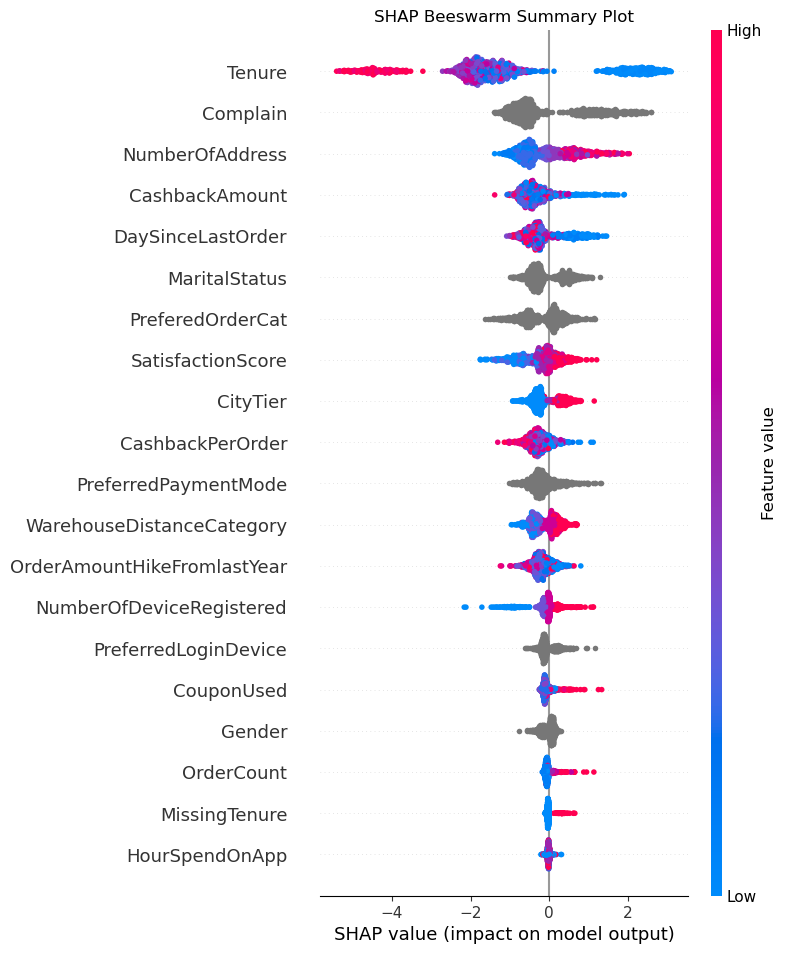

In [167]:
# SHAP Analysis on the Tuned XGBoost Model 
print("\n--- Generating SHAP Interpretability Plot for Tuned XGBoost ---")
shap.initjs()

# Tree explainer
explainer = shap.TreeExplainer(best_xgb_model)
shap_explanation = explainer(X_test_gb)

# Beeswarm Plot
shap.summary_plot(shap_explanation, X_test_gb, plot_type="dot", show=False, rng=np.random.default_rng(42))
plt.title("SHAP Beeswarm Summary Plot")
plt.show()

'Tenure' is undoubtedly the key predictor here, so let's plot the correlation with our target:

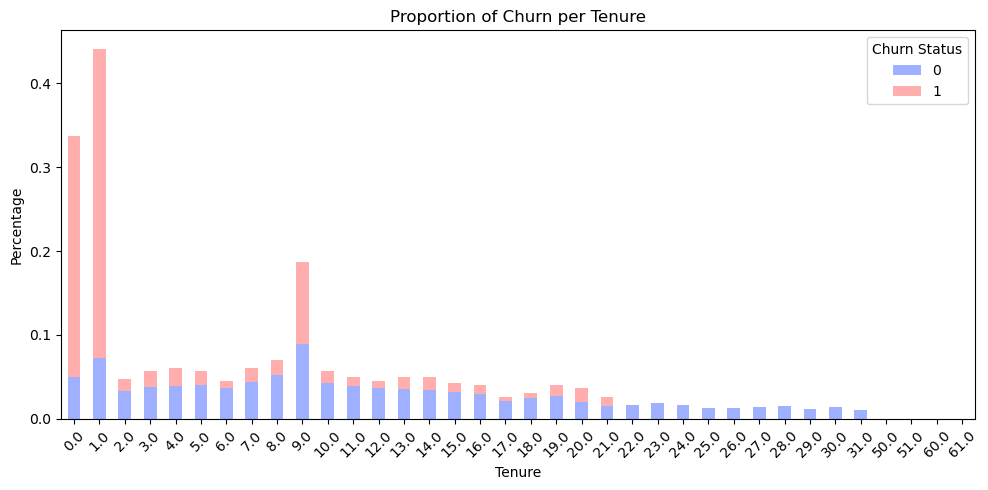

In [66]:
# Get proportion of churn within each tenure group
payment_crosstab = pd.crosstab(clean_df['Tenure'], clean_df['Churn'], normalize='columns')

# Plot
payment_crosstab.plot(kind='bar', stacked=True, colormap='berlin', figsize=(10, 5))
plt.title('Proportion of Churn per Tenure')
plt.ylabel('Percentage')
plt.xlabel('Tenure')
plt.xticks(rotation=45)
plt.legend(title='Churn Status')
plt.tight_layout()
plt.show()

To visualize the impact in a clearer way for categorical variables, we can plot their SHAP average value per category. 

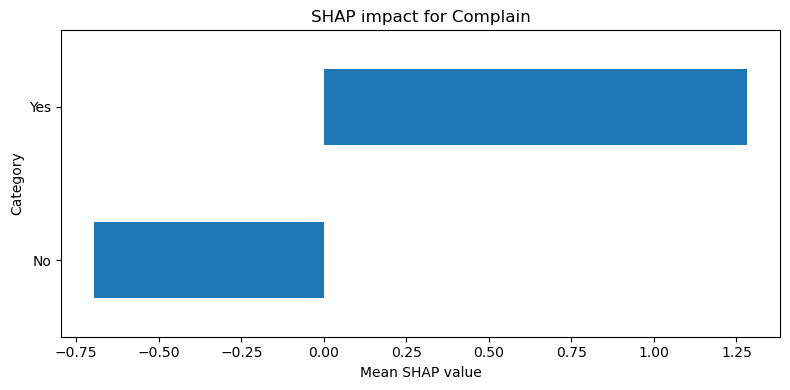

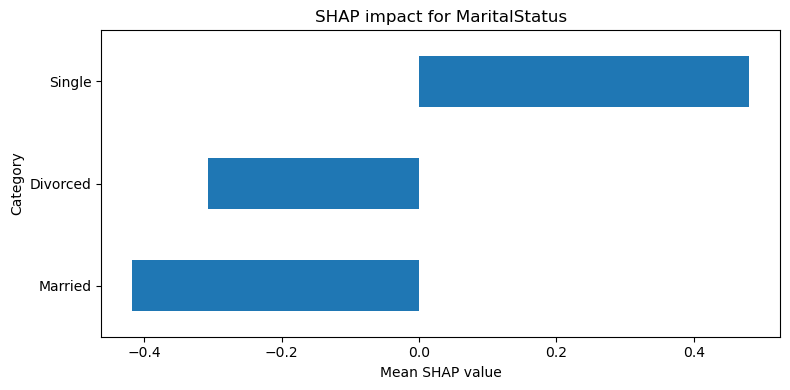

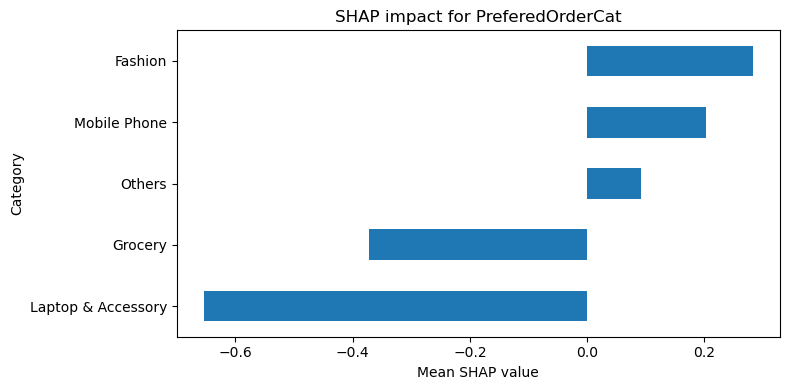

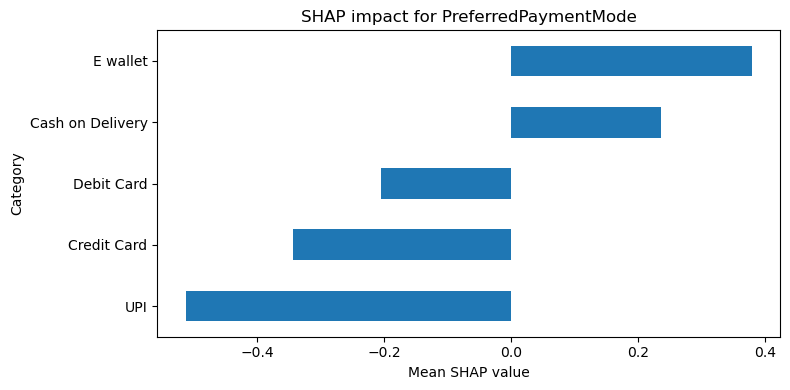

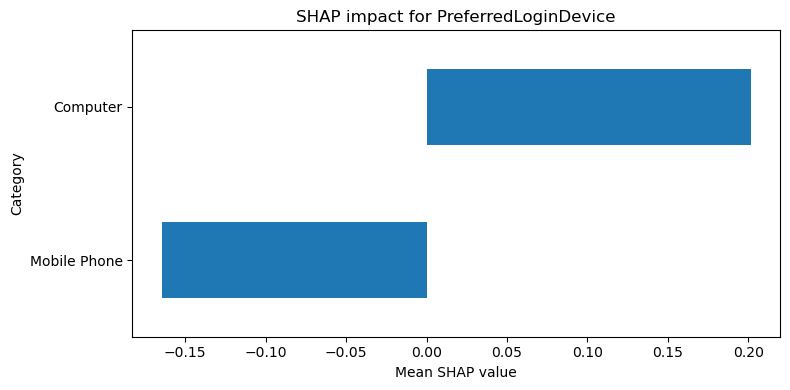

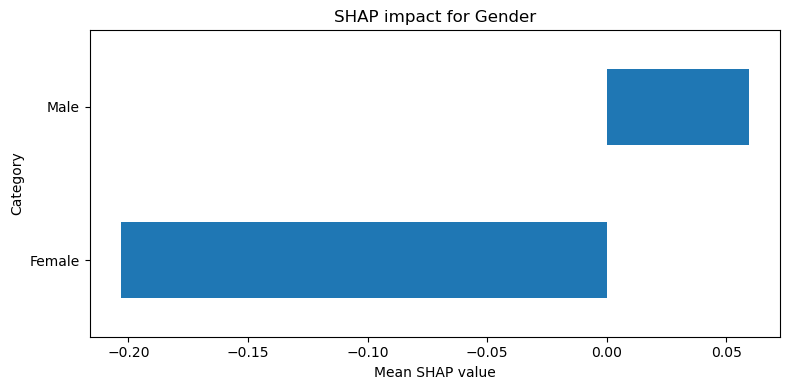

In [67]:
for col in ['Complain', 'MaritalStatus', 'PreferedOrderCat', 'PreferredPaymentMode', 'PreferredLoginDevice', 'Gender']:
    if col in X_test_gb.columns:
        shap_cat = pd.DataFrame({
            'Category': X_test_gb[col],
            'shap_value': shap_explanation[:, X_test_gb.columns.get_loc(col)].values
        })

        # Aggregate average SHAP impact by category
        shap_agg = shap_cat.groupby('Category', observed=False)['shap_value'].mean().sort_values()

        # Plot
        shap_agg.plot(kind='barh', title=f"SHAP impact for {col}", figsize=(8,4))
        plt.xlabel("Mean SHAP value")
        plt.tight_layout()
        plt.show()

### Most Impactful Positive & Negative Variables

SHAP values already give us a good idea of how our features impact churn predictions, but we can go a bit further and identify key drivers for churn and retention.

In [220]:
feature_values = pd.DataFrame(shap_explanation.data, columns=X_test_gb.columns)
shap_df = pd.DataFrame(shap_explanation.values, columns=X_test_gb.columns)

In [221]:
## Numerical Drivers of Churn
# Raw correlations
raw_corr = shap_df[numerical_features].corrwith(feature_values[numerical_features])

num_drivers = pd.DataFrame({
    'Feature': raw_corr.index,
    'Corr': raw_corr.values
})

# Rank by absolute impact
num_drivers['AbsCorr'] = num_drivers['Corr'].abs()
num_drivers = num_drivers.sort_values('AbsCorr', ascending=False).head(10)

# Interpret direction
num_drivers['DriverType'] = num_drivers.apply(lambda r: 'High Value → Churn' if r.Corr > 0 else 'Low Value → Churn', axis=1)
num_drivers['Type'] = 'Numerical'
num_drivers = num_drivers.reset_index(drop=True)

In [222]:
## Categorical drivers of churn
# Mean SHAP per category
cat_records = []
for col in categorical_features: 
    mean_shap = shap_df[col].groupby(feature_values[col]).mean()
    for category, val in mean_shap.items():
        cat_records.append({
            'Feature': '{col} = {cat}'.format(col=col, cat=category),
            'MeanSHAP': val,
            'AbsImpact': abs(val),
            'DriverType': 'Category → Churn' if val > 0 else 'Category → Retention',
            'Type': 'Categorical'
        })
cat_drivers = pd.DataFrame(cat_records)

# Rank by absolute impact
top_cat = cat_drivers.sort_values('AbsImpact', ascending=False).head(10).reset_index(drop=True)

In [223]:
combined = pd.concat([num_drivers[['Feature','Type','Corr','AbsCorr','DriverType']].rename(columns={'Corr':'Metric', 'AbsCorr':'AbsImpact'}),
                      top_cat[['Feature','Type','MeanSHAP','AbsImpact','DriverType']].rename(columns={'MeanSHAP':'Metric'})],
                     ignore_index=True)

combined = combined.sort_values('AbsImpact', ascending=False).reset_index(drop=True)

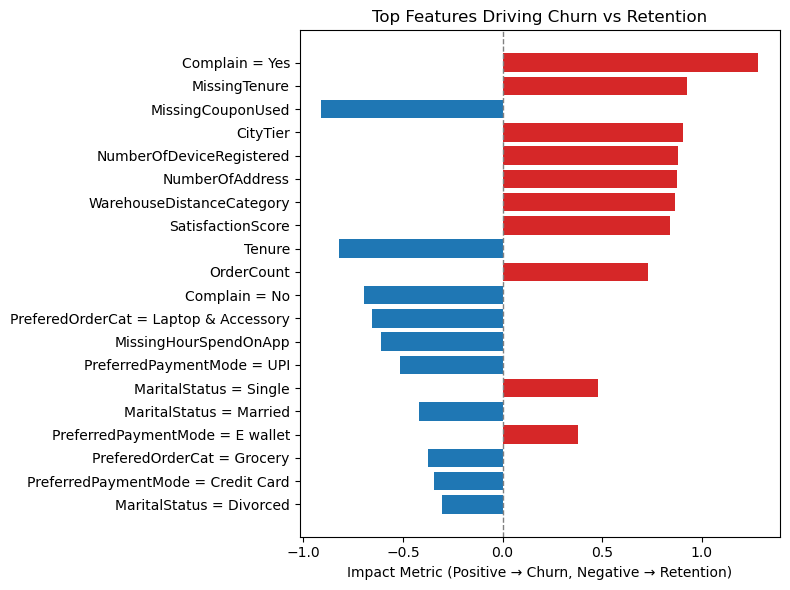

In [224]:
# Plotting for easier interpretation
plot_df = combined.sort_values('AbsImpact', ascending=True)
color_map = {
    'High Value → Churn': 'tab:red',
    'Low Value → Churn': 'tab:blue',
    'Category → Churn': 'tab:red',
    'Category → Retention': 'tab:blue'
}

plt.figure(figsize=(8, 6))
plt.barh(plot_df['Feature'], plot_df['Metric'], 
         color=[color_map[t] for t in plot_df['DriverType']])
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Impact Metric (Positive → Churn, Negative → Retention)')
plt.title('Top Features Driving Churn vs Retention')
plt.tight_layout()
plt.show()

Top features for churn prediction are here plotted by absolute impact, considering both numerical and categorical variables. Numerical features can either entertain a positive correlation with the target, meaning they are churn drivers (in red) or a negative correlation, meaning they are retention drivers (in blue). Categorical features are analyzed with respect to their unique values: a category can either be a churn driver (red) or a retention driver (blue). 

From the distribution above, we can clearly see the top churn drivers are the presence of complaints, the missingness of tenure, which likely translates either into customers being fairly new or not interested in establishing their relationship with the company, a large distance from home to warehouse and a high city tier. 

On the other hand, key indicators of retention are a high tenure, the missingness of used coupons, probably meaning that loyal customers don't need to use discounts every time the buy, a lack of complaints, and a preference for the 'Laptop & Accessories' category. 

## Classes of Churn Risk

In [ ]:
xgb_results = pd.DataFrame({
    'churn_actual': y_test,      
    'churn_proba': y_pred_proba           
})

# Create churn probability classes
bins = [0.0, 0.1, 0.7, 1.0]
labels = ['Low', 'Medium', 'High']
xgb_results['risk_cat'] = pd.cut(xgb_results['churn_proba'], bins=bins, labels=labels, include_lowest=True, right=False)

In [74]:
# Summarize performance per bin
summary = xgb_results.groupby('risk_cat', observed=False).agg(
    total_customers=('churn_actual', 'count'),
    churners=('churn_actual', 'sum'),
    churn_rate=('churn_actual', 'mean')
).reset_index()

summary

,risk_cat,total_customers,churners,churn_rate
0,Low,872,0,0.000000
1,Medium,68,9,0.132353
2,High,186,181,0.973118


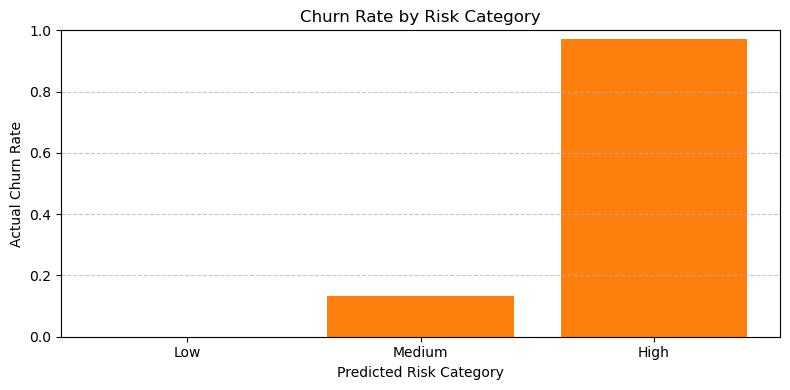

In [86]:
# Plot actual churn rate by predicted risk category
plt.figure(figsize=(8, 4))
plt.bar(summary['risk_cat'], summary['churn_rate'], color='C1')
plt.xlabel('Predicted Risk Category')
plt.ylabel('Actual Churn Rate')
plt.title('Churn Rate by Risk Category')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [82]:
# Compute counts and convert to row-wise percentages
counts = xgb_results.groupby(['churn_actual', 'risk_cat'], observed=False).size().unstack(fill_value=0)
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

percentages.index = ['Non-Churners', 'Churners']
percentages

risk_cat,Low,Medium,High
Non-Churners,93.162393,6.303419,0.534188
Churners,0.000000,4.736842,95.263158


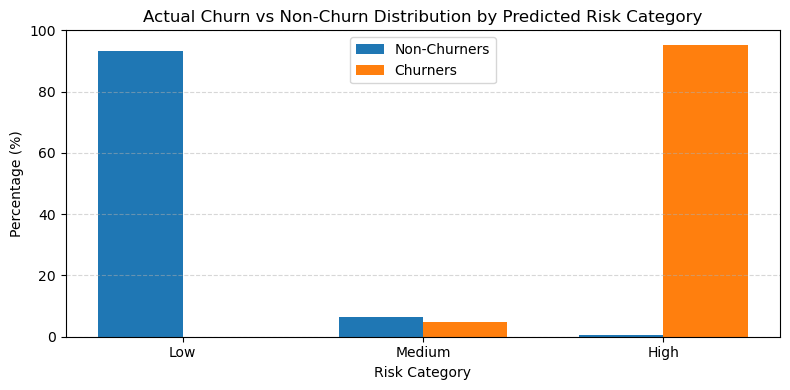

In [85]:
# Plot actual churn rate by predicted risk category
labels = percentages.columns.tolist()
non_churn = percentages.loc['Non-Churners'].values
churn = percentages.loc['Churners'].values

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 4))
plt.bar(x - width/2, non_churn, width, label='Non-Churners')
plt.bar(x + width/2, churn,     width, label='Churners')

plt.xticks(x, labels)
plt.xlabel('Risk Category')
plt.ylabel('Percentage (%)')
plt.title('Actual Churn vs Non-Churn Distribution by Predicted Risk Category')
plt.ylim(0, 100)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Summary of High Churn Probability Category

In [116]:
xgb_all_features = pd.DataFrame({
    'churn_actual': y_test,
    'churn_proba': y_pred_proba,
    **X_test_gb
}).reset_index(drop=True)

# Merge with risk categories
xgb_results.reset_index(drop=True, inplace=True)
xgb_all_features = xgb_all_features.join(xgb_results[['risk_cat']])
xgb_all_features.head()

,churn_actual,churn_proba,Tenure,PreferredLoginDevice,CityTier,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,...,CashbackAmount,MissingTenure,MissingWarehouseToHome,MissingHourSpendOnApp,MissingOrderAmountHikeFromlastYear,MissingCouponUsed,MissingOrderCount,WarehouseDistanceCategory,CashbackPerOrder,risk_cat
0,1,0.983554,19.0,Mobile Phone,3,E wallet,Male,3.0,2,Grocery,...,261.95,0,0,0,0,1,0,3,65.487500,High
1,0,0.015584,15.0,Computer,1,Debit Card,Female,3.0,6,Others,...,324.73,0,0,0,0,0,0,2,54.121667,Low
2,0,0.645271,1.0,Mobile Phone,3,UPI,Female,2.0,5,Mobile Phone,...,154.66,0,0,0,0,0,0,1,77.330000,Medium
3,0,0.016182,13.0,Mobile Phone,1,Debit Card,Female,3.0,4,Fashion,...,204.35,0,0,0,0,0,0,3,14.596429,Low
4,0,0.001441,4.0,Mobile Phone,3,Debit Card,Female,3.0,3,Laptop & Accessory,...,154.76,0,0,0,0,0,0,1,154.760000,Low


In [124]:
# High-risk customers study
high_risk = xgb_all_features[xgb_all_features['risk_cat'] == 'High']

In [138]:
# Compute numeric summaries
numerical_mean = ['CashbackAmount', 'CashbackPerOrder']
numerical_median = [col for col in numerical_features if col not in numerical_mean]

mean_summary_high = high_risk[numerical_mean].agg(['mean']).T
mean_summary_high.columns = ['Mean High-Risk']
mean_summary_overall = xgb_all_features[numerical_mean].agg(['mean']).T
mean_summary_overall.columns = ['Mean Overall']

median_summary_high = high_risk[numerical_median].agg(['median']).T
median_summary_high.columns = ['Median High-Risk']
median_summary_overall = xgb_all_features[numerical_median].agg(['median']).T
median_summary_overall.columns = ['Median Overall']

In [142]:
# Summary of numerical integer features
mean_summary = pd.concat([mean_summary_high, mean_summary_overall], axis=1)
mean_summary

,Mean High-Risk,Mean Overall
CashbackAmount,161.448871,176.250622
CashbackPerOrder,88.694186,95.593818


<Figure size 800x600 with 0 Axes>

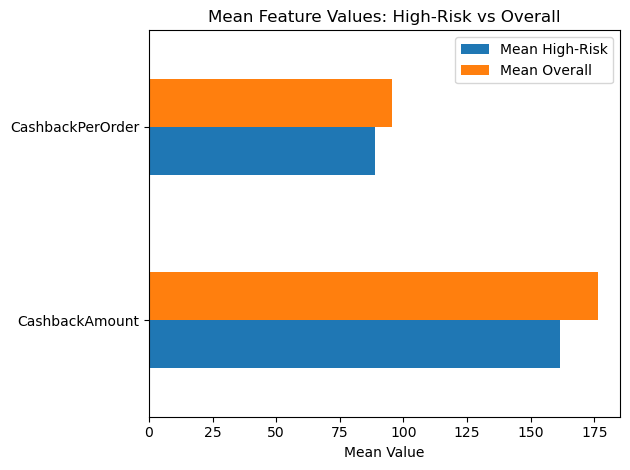

In [143]:
# Plot means
plt.figure(figsize=(8, 6))
mean_summary.plot(kind='barh')
plt.title('Mean Feature Values: High-Risk vs Overall')
plt.xlabel('Mean Value')
plt.tight_layout()
plt.show()

In [144]:
# Summary of numerical float features
median_summary = pd.concat([median_summary_high, median_summary_overall], axis=1)
median_summary

,Median High-Risk,Median Overall
Tenure,1.0,9.0
CityTier,1.0,1.0
HourSpendOnApp,3.0,3.0
NumberOfDeviceRegistered,4.0,4.0
SatisfactionScore,3.0,3.0
NumberOfAddress,3.0,3.0
OrderAmountHikeFromlastYear,15.0,15.0
CouponUsed,1.0,1.0
OrderCount,2.0,2.0
DaySinceLastOrder,2.0,3.0


<Figure size 800x600 with 0 Axes>

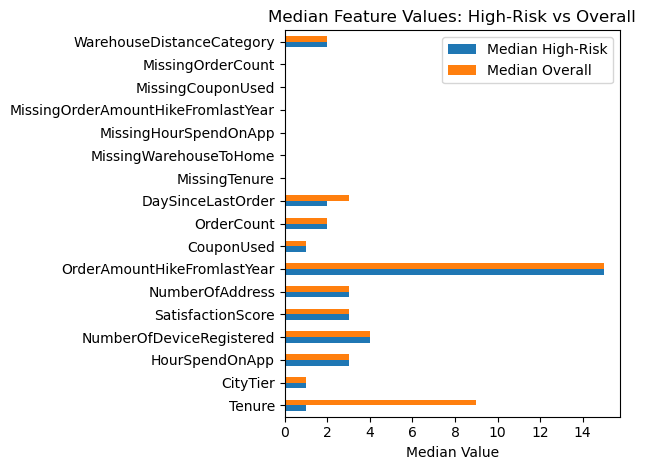

In [145]:
# Plot medians
plt.figure(figsize=(8, 6))
median_summary.plot(kind='barh')
plt.title('Median Feature Values: High-Risk vs Overall')
plt.xlabel('Median Value')
plt.tight_layout()
plt.show()

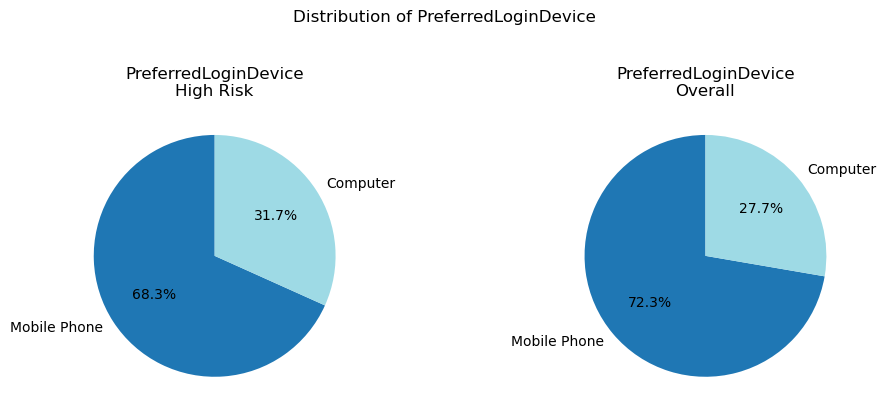

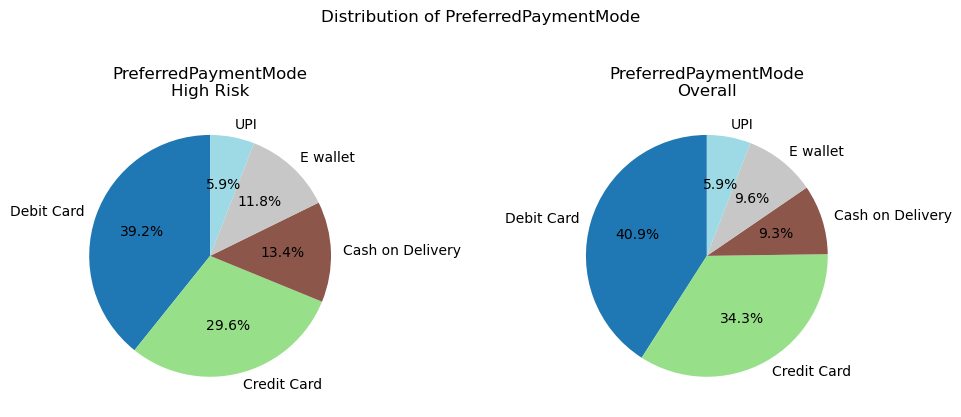

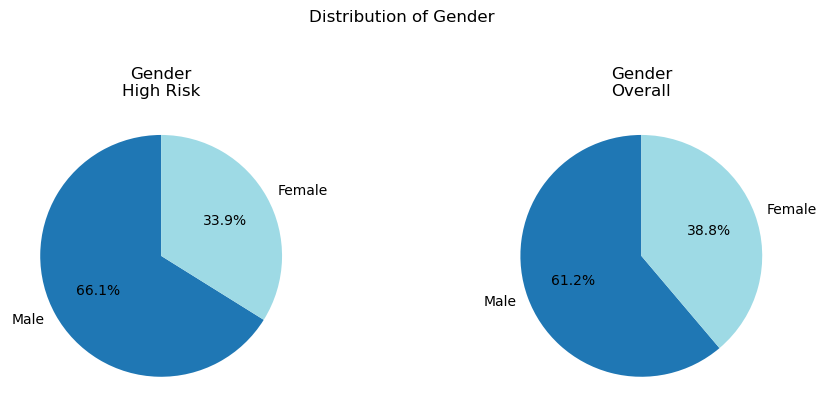

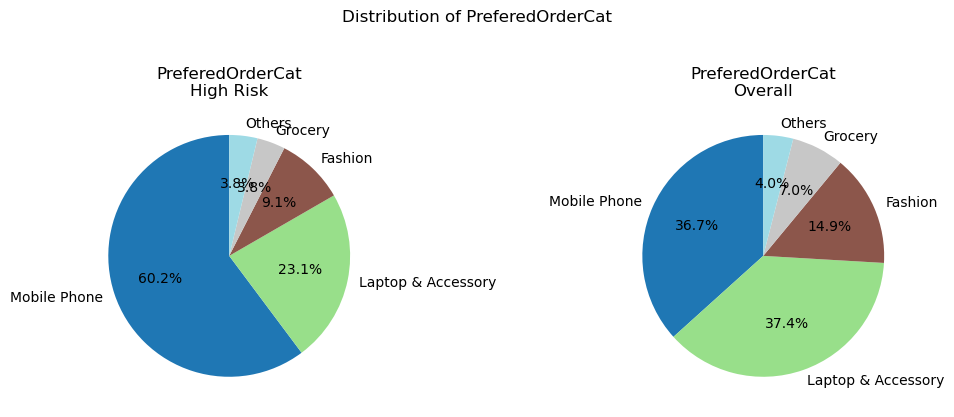

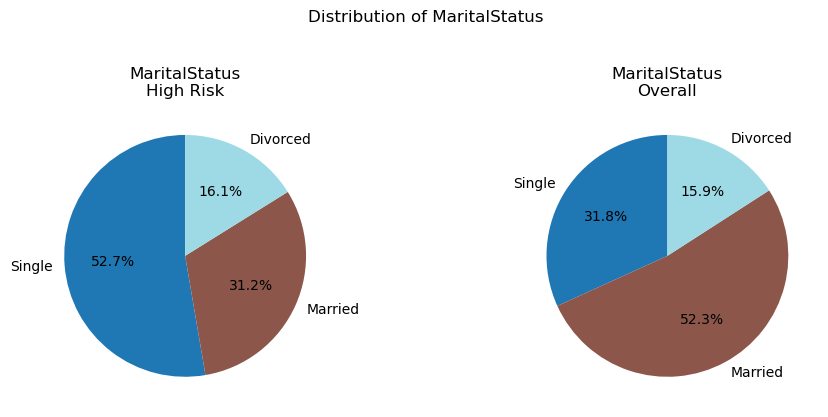

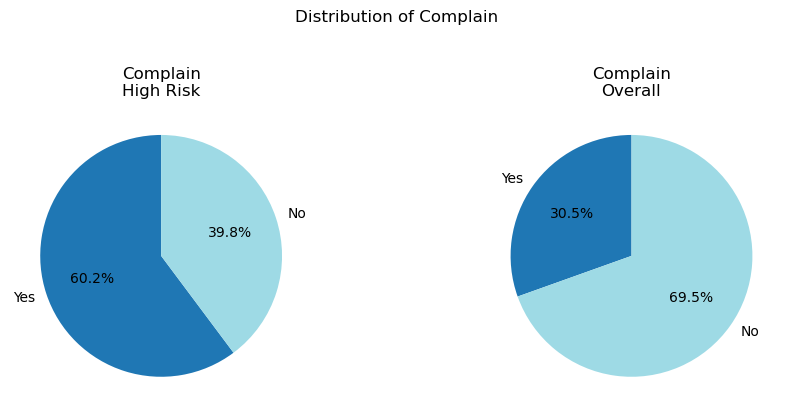

In [ ]:
# Visualize categorical breakdowns (high-risk vs overall)

for col in categorical_features:
    # High-risk vs Overall Distribution
    dist_high = high_risk[col].value_counts(normalize=True) * 100
    dist_full = xgb_all_features[col].value_counts(normalize=True) * 100

    # Assign colors to categories to avoid misassociation
    cats = list(dict.fromkeys(dist_high.index.tolist() + dist_full.index.tolist()))
    cmap = plt.get_cmap('tab20', len(cats))
    color_map = {cat: cmap(i) for i, cat in enumerate(cats)}

    sizes_high = [dist_high.get(cat, 0) for cat in cats]
    sizes_full = [dist_full.get(cat, 0) for cat in cats]

    # Plotting side-by-side pies
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.pie(sizes_high, labels=cats, autopct='%1.1f%%', startangle=90,
            colors=[color_map[cat] for cat in cats])
    ax1.set_title(f"{col}\nHigh Risk")

    ax2.pie(sizes_full, labels=cats, autopct='%1.1f%%', startangle=90,
            colors=[color_map[cat] for cat in cats])
    ax2.set_title(f"{col}\nOverall")
    plt.suptitle(f"Distribution of {col}", y=1.03)
    plt.tight_layout()
    plt.show()

From the feature summary of customers with high risk of churning, we can conclude that tenure is a key marker of loyalty: the longer a person has being part of the company's customer base, the less likely they are to leave. Other than that, we can see some driving factors of churn are:

- a lower median number of days since the last order (with respect to the whole customer base), which could describe an irregular behavior typical of customers prone to abandomnent;

- lower average cashback amount and cashback per order, suggesting that the incentives these customers are receiving are not high enough to keep them interested in continuing their affiliation with the company;

- a larger portion of preferred payment methods taken up by 'Cash on Delivery', probably reflecting the customers' reluctance to insert an online payment method, which translates into a lack of trust;

- a greater tendency to buy mobile related articles with respect to the overall CB, which could also be related to the significant change in marital status: high-risk customers are much more likely to be single and show less interest in buying more family-suited products (such as fashion or laptop & accessories categories) than married individuals, which predominate overall;

- a significantly higher complain rate, which is not surprising at all, and highlights the customers' unsatisfied state.

### Churn Probability by Tenure

In [ ]:
# Tenure ranges and labels
tenure_bins  = [0, 5, 10, 15, 20, 25, np.inf] 
tenure_labels = ['<= 5','6-10','11-15','16-20','21-25','>25']  

tenure_df = xgb_all_features.copy()
tenure_df['TenureRange'] = pd.cut(tenure_df['Tenure'], bins=tenure_bins, labels=tenure_labels, right=True, include_lowest=True)

# Overall % of customers in each tenure range
total = len(tenure_df)
range_counts = tenure_df['TenureRange'].value_counts(sort=False) 
pct_of_customers = (range_counts / total * 100).rename('% Customers')

# Distribution of risk categories *within* each tenure range
dist = (
    tenure_df
    .groupby(['TenureRange','risk_cat'], observed=False)
    .size()
    .unstack(fill_value=0)
)
dist_pct = dist.div(dist.sum(axis=1), axis=0) * 100

tenure_summary = pd.concat([pct_of_customers, dist_pct], axis=1).round(1)
tenure_summary




,% Customers,Low,Medium,High
TenureRange,,,,
<= 5,36.0,53.3,13.1,33.6
6-10,24.2,85.7,4.4,9.9
11-15,16.3,94.5,1.1,4.4
16-20,10.4,88.9,0.0,11.1
21-25,6.9,96.2,1.3,2.6
>25,6.2,100.0,0.0,0.0


As expected, the majority of high-tenure customers are low-risk, while new customers (especially <5) are at high risk of churning.

## Proposed Marketing Strategies

Since distinct churn drivers were identified, we can build different customer segments on top of them. This allows for personalized, cost-effective interventions instead of a one-size-fits-all approach. In particular, I will suggest four targeted approaches:

1. Segment **"New & At-Risk Onboarding"**: customers display low tenure, a very strong churn indicator, and also hold a record of complaints. They haven't formed a habit yet or are likely lapsing after their first few purchases. The stategy is based on intensive onboarding & first-month engagement campaign, which could translate into automated notifications triggered after the first purchase that highlights the platform's key benefits (e.g., cashback loyalty programs), a compelling discount offer to redeem over a short time period, with the goal of building a habit, or a one-click satisfaction survey after the first order delivery, to proactively catch any early negative experiences.

2. Segment **"Service Recovery"**: tenure is longer, but customers are characterized by a high complain rate among churners, which is a major red flag indicating active dissatisfaction. Here, the strategy focuses on proactive follow-up & recovery offers: after a thorough support from customer service, the client should receive, via their preferred communication channel, a special "we're sorry" credit or a high-value coupon for their next purchase. This acknowledges the poor experience and shows the company values their business, turning a negative interaction into a potential positive one. Indeed, a customer whose problem is handled exceptionally well can become even more loyal than one who never had an issue. 

3. Segment **"Under-Engaged with Loyalty"**: churners have a lower average CashbackAmount and CashbackPerOrder, which means they aren't feeling the benefits of the loyalty program.
A strategy grounded in loyalty program education and gamification could increase the conversion of at-risk customers into the more loyal, high-engagement group by actively encouraging their participation in the program.

4. Segment **"Trust-Sensitive COD Users"**: churning customers show their lack of trust in online payments or friction in the payment process, by favoring Cash on Delivery (COD) instead. A solution could be a campaign to incentivize digital payment conversion, displaying trust badges and highlight the convenience of faster checkout with saved cards, and possibly reserving some special treatment specifically upon adding Debit of Credit Card information for the first time. Converting a COD user to a digital payment method reduces transaction friction, lowers operational costs due to cash handling, and signifies an increase in their trust and integration with the platform, making them "stickier."

In [164]:
high_risk_customers = high_risk.copy()

def assign_segment(row):
    # Highest priority: new customers who complained
    if row['Tenure'] <= 1 and row['Complain'] == 'Yes':
        return 'New & At-Risk Onboarding'
    
    # High priority: long-tenured customers who complained
    elif row['Tenure'] > 1 and row['Complain'] == 'Yes':
        return 'Service Recovery'
        
    # Medium priority: customers showing lack of trust during checkout
    elif row['PreferredPaymentMode'] == 'Cash on Delivery':
        return 'Trust-Sensitive COD Users'
        
    # Medium priority: customers not getting the most out of loyalty program
    elif row['CashbackPerOrder'] < 150: 
        return 'Under-Engaged with Loyalty'
        
    # A general bucket for anyone else flagged
    else:
        return 'General Churn Risk'

# Create segmentation for high-risk customers
if not high_risk_customers.empty:
    high_risk_customers['MarketingSegment'] = high_risk_customers.apply(assign_segment, axis=1)
else:
    print("\nNo high-risk customers were predicted in the test set with the current threshold.")

In [165]:
# Let's visualize a couple examples from each segment
relevant_columns = [
    'Tenure',
    'Complain',
    'PreferredPaymentMode',
    'CashbackPerOrder',
    'churn_proba',
    'MarketingSegment'
]

examples_per_segment = high_risk_customers.groupby('MarketingSegment').head(2)
examples_per_segment = examples_per_segment.sort_values(by='MarketingSegment')
examples_per_segment = examples_per_segment[examples_per_segment['MarketingSegment'] != 'General Churn Risk']

for segment_name, segment_df in examples_per_segment.groupby('MarketingSegment'):
    print(f"\n\n--- Segment: {segment_name} ---")
    if len(segment_df) > 0:
        print(segment_df[relevant_columns].to_string())
    else:
        print("No examples to display for this segment.")



--- Segment: New & At-Risk Onboarding ---
    Tenure Complain PreferredPaymentMode  CashbackPerOrder  churn_proba          MarketingSegment
25     1.0      Yes           Debit Card            74.095     0.947369  New & At-Risk Onboarding
47     0.0      Yes             E wallet            80.670     0.984147  New & At-Risk Onboarding


--- Segment: Service Recovery ---
    Tenure Complain PreferredPaymentMode  CashbackPerOrder  churn_proba  MarketingSegment
0     19.0      Yes             E wallet           65.4875     0.983554  Service Recovery
19     9.0      Yes          Credit Card           61.4650     0.899569  Service Recovery


--- Segment: Trust-Sensitive COD Users ---
     Tenure Complain PreferredPaymentMode  CashbackPerOrder  churn_proba           MarketingSegment
85      0.0       No     Cash on Delivery            131.02     0.986930  Trust-Sensitive COD Users
104     0.0       No     Cash on Delivery            125.64     0.982742  Trust-Sensitive COD Users


--- Segme